# Project 2 - Algorithmic methods for data mining
## Construction of the graph
Cristina Menghini - StudentID : 1527821

At first I define the collection of Project db that I will use to store the informations about the graph.

In [6]:
import pymongo
from pymongo import MongoClient
# Define the client of the db
client = MongoClient('localhost', 27017)
# Create the database
project_2 = client['Project']

In [7]:
# Create the collection for the graph infos
collection = project_2['Collection_Project']
gr_in = project_2.graph_info

Once the data have been collected, I work on the construction of the graph. In my case it is related to the query 'yearofmercy'. Before beginning I create the directed graph G, which will represent the network.

In [3]:
import networkx as nx

In [4]:
G = nx.DiGraph(topic = 'Year of mercy')

# 1. Nodes

In [5]:
import pickle

The first step to do to build the graph is define the nodes it will be composed by. They have already been stored in the user_tweet collection of Project database and saved in the the 'users.p' file. 


In [9]:
if project_2.user_tweet.count() == 0: # If the local MongoDB han not been filled.
    print 'if'
    nodes = list(pickle.load(open('users.p', 'rb'))) # Each user is a node of the graph
else:
    node = []
    for post in project_2.user_tweet.find():
        node += [post['user_id']]
    nodes = list(set(node))

I get the list of nodes, hence I add them to the graph.

In [13]:
G.add_nodes_from(nodes) # Adding nodes to the graph

I fill in the collection the first information about the graph: the number of nodes which it's composed.

In [14]:
num_nodes = G.order() # Number of nodes
gr_in.insert_one({'Number of nodes' : str(num_nodes)})

# 2. Edges

Since I want to study the relations and connections between the users( nodes), I add to the graph the edges. 
Distinguish between users and list of followers( each of whose is a user too), each users will be pointed by each of his followers. It's why I define a directed graph.

I proceed loading the edges from the file created in the previous steps during which I stored the followers and the relative user id.

In [15]:
if project_2.user_followers.count() == 0: # If the db hasn't be filled 
    foll_saved = pickle.load(open('save.p','rb')) 
else:
    foll_saved = [] # Load from the DB
    for post in project_2.user_followers.find():
        foll_saved += [post]

In [17]:
# Distinguish between users and followers to create the tuple from which I'll extract the edges.
follower = [foll_saved[k]['follower'] for k in range(len(foll_saved))]
user_ids = [foll_saved[k]['user_id'] for k in range(len(foll_saved))]
# Tuple of edges
edges = zip(follower, user_ids)

So, I fill in the graph the edges.

In [18]:
G.add_edges_from(edges) # Adding edges to the graph

I insert in the collection also the size( number of archs).

In [20]:
num_edges = G.size()
gr_in.insert_one({'Number of edges' : str(num_edges)})

# 4. Analyze the graph

## 4.1 Degree distribution

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
G_deg = G.degree(G.nodes())
G_deg_values = sorted(G_deg.values(), reverse = True)

The following graph shows the degree( sum of in and out degree) distribution of the graph. As you see, according to the power-law, the number of users with the higest degrees is tiny, on the other hand the small values of degree correspond to an higher number of users.

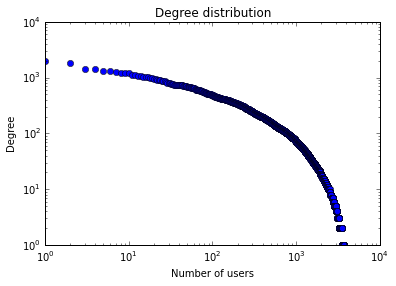

In [14]:
plt.loglog(G_deg_values,'o')
plt.title('Degree distribution')
plt.xlabel('Number of users')
plt.ylabel('Degree')

## 4.2 Centralities

### 4.2.1 In-degree and out degree centrality

The first measure of centrality I'm going to perform is the degree centrality. Since I'm considering a directed graph I'm going to compute a differentiated in-degree and out-degree centrality. Intuitively the nodes which correspond an highest value of in-degree centrality is maybe a popular twitter user reguarding the topic of my query, whereas the one with an high value of out-degree is considered as gregariousness.

In [32]:
def getKey(item):
    """This function gives back the second element of a tuple.
    -item is the tuple"""
    return item[1]

In [33]:
# In-degree centrality
in_deg_centrality = nx.in_degree_centrality(G)
tuples_in_deg = in_deg_centrality.items()
in_deg_centralities_sorted = sorted(tuples_in_deg, key = getKey)
top_10_in_deg_centr = in_deg_centralities_sorted[-10:]

The plot below shows the distribution of the in-degree centrality, also in that case we observe the presence of a very restricted number of users that may be considered 'popular'.

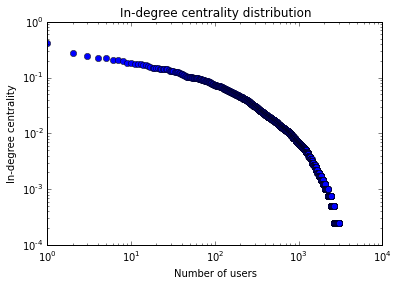

In [28]:
in_deg_values = sorted(in_deg_centrality.values(), reverse =  True)
plt.loglog(in_deg_values, 'o')
plt.title('In-degree centrality distribution')
plt.xlabel('Number of users')
plt.ylabel('In-degree centrality')

In [34]:
# Out-degree centrality
out_deg_centrality = nx.out_degree_centrality(G)
tuples_out_deg = out_deg_centrality.items()
out_deg_centralities_sorted = sorted(tuples_out_deg, key = getKey)
top_10_out_deg_centr = out_deg_centralities_sorted[-10:]

Respect the previous plot, aboiut the in-degrees cerntrality distribution, the plot below shows a sharply decrease of the out-degree centrality when the number of nodes that present that value increases. A part from this, the overall distributions are more ore less the same.

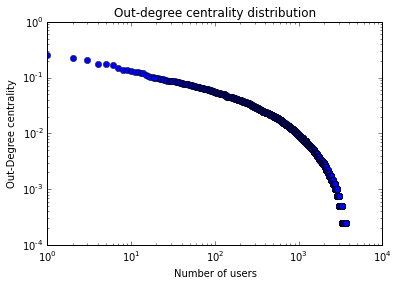

In [29]:
out_deg_values = sorted(out_deg_centrality.values(), reverse =  True)
plt.loglog(out_deg_values, 'o')
plt.title('Out-degree centrality distribution')
plt.xlabel('Number of users')
plt.ylabel('Out-Degree centrality')

### 4.2.2 Closeness centrality

In [35]:
# Closeness centralities
clos_centrality = nx.closeness_centrality(G)
clos_values = sorted(clos_centrality.values(), reverse =  True)

In [36]:
# Get the top 10 nodes 
tuples_clos = clos_centrality.items()
clos_centralities_sorted = sorted(tuples_clos, key = getKey) # Sort the nodes according to their centrality values
top_10_clos_centr = clos_centralities_sorted[-10:]

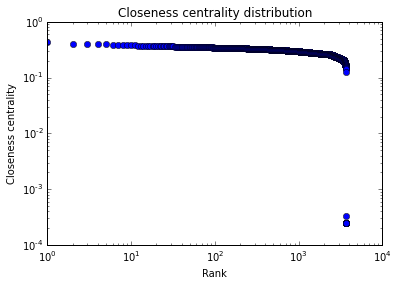

In [105]:
#Plot of the closeness centrality distribution
plt.loglog(clos_values, 'o')
plt.title('Closeness centrality distribution')
plt.xlabel('Rank')
plt.ylabel('Closeness centrality')

### 4.2.3 Betweeness centrality

Computation of the betweenes of the graph will take some time, as an alternative you can skip to run this line of code and just go ahead to the next one where I recall a document that stores the betweenes already computed.

In [106]:
# Betweeness centralities
btw_centrality = nx.betweenness_centrality(G)
import pickle
pickle.dump( btw_centrality, open('betweeness.p', 'wb')) # Store the variable file.

Already computed betweeness

In [37]:
btw_centrality = pickle.load(open('betweeness.p','rb')) # Load the betweenes centrality

In [38]:
btw_values =  sorted(btw_centrality.values(), reverse = True)

In [41]:
tuples_btw = btw_centrality.items()
btw_centralities_sorted = sorted(tuples_btw, key = getKey)
top_10_btw_centr = btw_centralities_sorted[-10:]

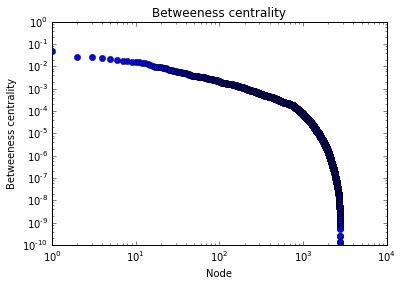

In [111]:
#Plot of the betweeness centrality 
plt.loglog(btw_values, 'o')
plt.title('Betweeness centrality')
plt.xlabel('Node')
plt.ylabel('Betweeness centrality')

### 4.2.4 Page Rank centralities

Now I'm going to compute the Page Rank centrality as a way of measuring the importance of a user.

In [39]:
# Page rank centrality
pr_centrality = nx.pagerank(G)
tuples_pr = pr_centrality.items()
pr_centralities_sorted = sorted(tuples_pr, key = getKey)
top_10_pr_centr = pr_centralities_sorted[-10:]

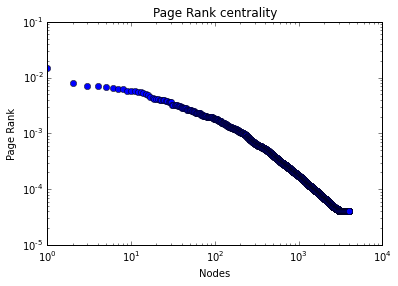

In [194]:
# Plot of the PageRank centrality
plt.loglog(sorted(pr_centrality.values(),reverse = True), 'o')
plt.title('Page Rank centrality')
plt.xlabel('Nodes')
plt.ylabel('Page Rank')

### 4.2.5 Fill in the database

Create the collections that contains the informations of each node of the graph.

In [199]:
# Create the collection for the nodes infos
collection = project_2['Collection_Project']
no_in = project_2.nodes_info

In [200]:
no_in.insert_many([{'Node' : nodes[n], 'In-degree centrality' : in_deg_centrality[nodes[n]] , 'Out-degree centrality' : out_deg_centrality[nodes[n]], 'Closness centrality' : clos_centrality[nodes[n]], 'Betweeness centrality' : btw_centrality[nodes[n]], 'Page Rank centrality' : pr_centrality[nodes[n]]} for n in range(len(nodes))])

### 4.2.6 Summary

Before building the summary table, I need to get the screen names of the users. Hence, first I create a unique list of the most relevant( according to the centralities) users, then retrieve their screen name and finally create a dictionary likes:

                        {'user' : '19283', 'screen_name' : 'picchiopazzerello'}

In [45]:
# Create the list of top 10 users
tops_list =  top_10_btw_centr+top_10_clos_centr+top_10_in_deg_centr+top_10_out_deg_centr+top_10_pr_centr
list_top = []
for i in range(len(tops_list)):
    list_top += [tops_list[i][0]]

In [46]:
# Do the set of the list_top, to pick the user each of whose I'm going to retrieve the screen name
set_top = set(list_top)

In [43]:
import tweepy
from tweepy import OAuthHandler

In [44]:
cfg = { 
    "consumer_key"        : "FIdkHUbZuNjNxyPfImqI9TFXN",
    "consumer_secret"     : "lVyiiX67XiU3EkvsrC20yj2pDPhsQvUNFGr2FuGdvdmJxd1vwM",
    "access_token"        : "633193657-arMpLiTtLAlAGDfkUUqcPnx4obmgrE7VkTRUgJmO",
    "access_token_secret" : "2TLsxc9FUYUYVpeaTkPGkuL7Nmk5PwQQv5q9JbdrACZh8" 
}

auth = OAuthHandler(cfg["consumer_key"], cfg["consumer_secret"])
auth.set_access_token(cfg["access_token"], cfg["access_token_secret"]) 
api = tweepy.API(auth)

In [47]:
# Retrieve the screen names
dic_screen_names = {}
for s in set_top:
    dic_screen_names[s] = api.get_user(s).name

To summarize the analisys of different kind of centralities I build the following table that shows the top ten of each centrality.

Top 10 | In-degree | Out-degree | Closeness | Betweeness | Page Rank
:-:|:-:|:-:|:-:|:-:|:-:|
1 | Catholic News Agency | TradCatKnight| TradCatKnight | Catholic News Agency | Catholic News Svc |
2 | Catholic News Svc | Fr Matthew Schneider | Fr Matthew Schneider | TradCatKnight | Catholic News Agency |
3 | N. Catholic Register| Catholic News Agency | Kathryn Jean Lopez | Kathryn Jean Lopez | N. Catholic Register |
4 | James Martin, SJ | Kathryn Jean Lopez | Catholic News Agency | CatholicsFollowBack | Rocco Palmo |
5 | Our Sunday Visitor | Fr. Willy Raymond | Fr. Willy Raymond | American Catholic | Our Sunday Visitor |
6 | Catholic Herald | Dr. Brian Kiczek | Dr. Brian Kiczek | Dr. Brian Kiczek | James Martin, SJ |
7 | Sr Helena Burns, fsp | CatholicsFollowBack | CatholicsFollowBack | Catholic News Svc | Archbishop Gomez |
8 | Knights of Columbus | Power of the Rosary | Power of the Rosary | Sr Helena Burns, fsp | Knights of Columbus |
9 | Archbishop Gomez | James Goodman | James Goodman | Our Sunday Visitor | Catholic Herald |
10 | Rocco Palmo | Fr Brad Sweet | SonsofSaintJoseph | James Goodman | Sr Helena Burns, fsp |

Focusing on the top 3 users of the different centralities, we find that:

-Respect the network I'm studying the most popular Twitter users( In-degree centrality), related to the topic 'yearofmercy', are three pages of information about the Catholic World. Infact, pursuant to their Twitter descriptions:
   - Chatholic News Agency provides the latest news about the Catholic Church and the Catholic faithful.
   - Catholic News Svc is a leader in religious news. "Our mission is to report fully, fairly and freely on the involvement of the church in the world today."
   - N. Catholic Register, "Our mission is to inform, inspire, challenge and equip active Catholics to engage the culture with confidence."



-
The importance of these pages in the network is also stressed by leaderboard related to the PageRank centrality.



-
Reguarding the out-degree and closeness centrality we observe the importance of the TradCatKnight, which is a page dedicated to the Traditional Catholicism, and Fr Matthew Schneider, who is a Catholic religious priest, are both predominant.



-
The three users that appear the high number of time in the paths that connect users are the Chatholic News Agency, the TradCatKnight and Kathryn Jean Lopez that menages a National Review Online.

N.B.
The previous table and considerations will not be created automatically by the code, are just hand-made. If you want to obtain the information that I fill in the table by hand just follow that procedure:

In [49]:
centralities = [top_10_in_deg_centr,top_10_out_deg_centr, top_10_btw_centr, top_10_clos_centr, top_10_pr_centr]

In [68]:
names = []
for j in range(len(centralities)):
    names.append([dic_screen_names[centralities[j][i][0]] for i in range(len(centralities[j]))])

Each list of names, goes from the top to the bottom.

## 4.3 Clustering coefficient

The clustering coefficient is the most common way of measuring the correlation coefficient that tell us how much do friends of friends tend to be friend.

### 4.3.1 Clustering coefficient of some nodes of the graph

In [21]:
# Choose nodes randomly
import numpy as np
indices = np.random.randint(0,len(nodes), size = 20)
sub_nodes = [nodes[i] for i in indices]

In [22]:
#Compute their clustering coefficient
G_un = G.to_undirected()
clu_coeff = nx.clustering(G_un, sub_nodes)

### 4.3.2 Clustering coefficient of the graph

In [23]:
# Compute the global clustering coefficient as the average clustering coefficient
avg_coeff = nx.average_clustering(G_un)

As an information of the graph I insert it to the collection graph_information of the Project db.

In [24]:
gr_in.insert_one({'Average clustering coefficient' : str(avg_coeff)})

## 4.4 Connected components

In [73]:
from collections import defaultdict

In [25]:
# Compute the connected components of the graph
CC = nx.connected_components(G_un)
num_connected_com = nx.number_connected_components(G_un) # number of connected components
print num_connected_com

305


Insert the number of connected components in the collection graph_info.

In [26]:
gr_in.insert_one({'Number of CC' : str(num_connected_com) })

In [90]:
order_CC = defaultdict(int)
for c in CC:
    order_CC[len(c)] += 1 # Count how many components have the same length

The graph has 305 connected components, 293 of whose are composed by one node, 10 by two nodes, and one big component include 3729 nodes, it means that any two users of the 3729 users of the biggest component are connected to each other by paths.

In [91]:
order_CC

defaultdict(int, {1: 293, 2: 10, 3: 1, 3729: 1})

## 4.5 K-core decomposition

Since the value of K is not specified, I let the algorithm work antil the value of k after that we would ha the degeneracy of the graph.

In [92]:
# Perform the k-core decomposition of the largest graph
largest_connected_components = max(list(nx.connected_component_subgraphs(G_un)), key = len)
k_core_decomposition = nx.k_core(largest_connected_components)

In [97]:
degrees_k_core = []
for k in k_core_decomposition:
    degrees_k_core += [G.degree(k)] # The elements of degrees_k_core list are the degrees of each node that belong the K-core

In [100]:
k = min(degrees_k_core)

The k of the graph before the degeneracy is 153.